In [2]:
# 변동성 돌파 단타 전략 - BigQuery 데이터 불러오기

import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# matplotlib 한글 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

## 1. 필요한 라이브러리 임포트 및 환경 설정

In [3]:
# BigQuery 연결 설정
def get_bigquery_client():
    """BigQuery 클라이언트 초기화"""
    # CLAUDE.md에 정의된 서비스 계정 경로
    service_account_path = "/Users/cg01-piwoo/my_quant/access_info/data/quantsungyong-663604552de9.json"
    
    credentials = service_account.Credentials.from_service_account_file(
        service_account_path,
        scopes=["https://www.googleapis.com/auth/cloud-platform"]
    )
    
    client = bigquery.Client(credentials=credentials, project=credentials.project_id)
    return client

# 클라이언트 초기화
client = get_bigquery_client()
print("BigQuery 클라이언트 초기화 완료")

BigQuery 클라이언트 초기화 완료


## 2. BigQuery 클라이언트 초기화

In [4]:
def get_stock_data(ticker, start_date=None, end_date=None):
    """
    BigQuery에서 주가 데이터를 가져오는 함수
    
    Parameters:
    - ticker: 종목 티커 (예: 'AAPL', 'SPY')
    - start_date: 시작 날짜 (YYYY-MM-DD 형식)
    - end_date: 종료 날짜 (YYYY-MM-DD 형식)
    
    Returns:
    - DataFrame: 주가 데이터
    """
    
    # 날짜 조건 설정
    date_conditions = []
    if start_date:
        date_conditions.append(f"JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') >= '{start_date}'")
    if end_date:
        date_conditions.append(f"JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') <= '{end_date}'")
    
    date_filter = f"AND {' AND '.join(date_conditions)}" if date_conditions else ""
    
    # BigQuery 쿼리 - stock_data_with_indicators 테이블 사용
    query = f"""
    WITH raw_data AS (
      SELECT 
        ticker,
        
        -- 가격 데이터
        JSON_EXTRACT_ARRAY(data, '$.dates') AS dates_array,
        JSON_EXTRACT_ARRAY(data, '$.open') AS open_array,
        JSON_EXTRACT_ARRAY(data, '$.high') AS high_array,
        JSON_EXTRACT_ARRAY(data, '$.low') AS low_array,
        JSON_EXTRACT_ARRAY(data, '$.close') AS close_array,
        JSON_EXTRACT_ARRAY(data, '$.volume') AS volume_array,
        
        -- RSI
        JSON_EXTRACT_ARRAY(data, '$.rsi_14_values') AS rsi_14_values_array,
        
        -- MACD
        JSON_EXTRACT_ARRAY(data, '$.macd_line') AS macd_line_array,
        JSON_EXTRACT_ARRAY(data, '$.macd_9_signal_line') AS macd_9_signal_line_array,
        JSON_EXTRACT_ARRAY(data, '$.macd_histogram') AS macd_histogram_array,
        
        -- 배열 길이
        ARRAY_LENGTH(JSON_EXTRACT_ARRAY(data, '$.close')) AS array_length
        
      FROM 
        `quantsungyong.finviz_data.stock_data_with_indicators`
      WHERE 
        ticker = '{ticker}'
    ),

    -- 인덱스 생성
    indices AS (
      SELECT 
        r.ticker,
        pos
      FROM raw_data r,
      UNNEST(GENERATE_ARRAY(0, r.array_length - 1)) AS pos
    )

    -- 최종 RDB 형식으로 변환
    SELECT 
      -- 날짜와 가격 데이터
      JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') AS date,
      CAST(JSON_EXTRACT_SCALAR(r.open_array[OFFSET(i.pos)], '$') AS FLOAT64) AS open,
      CAST(JSON_EXTRACT_SCALAR(r.high_array[OFFSET(i.pos)], '$') AS FLOAT64) AS high,
      CAST(JSON_EXTRACT_SCALAR(r.low_array[OFFSET(i.pos)], '$') AS FLOAT64) AS low,
      CAST(JSON_EXTRACT_SCALAR(r.close_array[OFFSET(i.pos)], '$') AS FLOAT64) AS close,
      CAST(JSON_EXTRACT_SCALAR(r.volume_array[OFFSET(i.pos)], '$') AS INT64) AS volume,
      
      -- RSI
      CASE 
        WHEN ARRAY_LENGTH(r.rsi_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.rsi_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS rsi_14,
      
      -- MACD
      CASE 
        WHEN ARRAY_LENGTH(r.macd_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_9_signal_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_9_signal_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_signal,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_histogram_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_histogram_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_histogram,
      
      -- 변화율 계산
      CASE 
        WHEN i.pos > 0 THEN 
          ROUND((CAST(JSON_EXTRACT_SCALAR(r.close_array[OFFSET(i.pos)], '$') AS FLOAT64) - 
                 CAST(JSON_EXTRACT_SCALAR(r.close_array[OFFSET(i.pos-1)], '$') AS FLOAT64)) / 
                 CAST(JSON_EXTRACT_SCALAR(r.close_array[OFFSET(i.pos-1)], '$') AS FLOAT64) * 100, 2)
        ELSE NULL 
      END AS change_pct
      
    FROM 
      raw_data r
    CROSS JOIN 
      indices i
    WHERE
      i.ticker = r.ticker
      {date_filter}
    ORDER BY 
      date DESC
    """
    
    # 쿼리 실행
    try:
        df = client.query(query).to_dataframe()
        
        # 날짜 컬럼을 datetime으로 변환
        df['date'] = pd.to_datetime(df['date'])
        
        # 인덱스를 날짜로 설정
        df.set_index('date', inplace=True)
        
        # 오름차순 정렬 (시간순)
        df.sort_index(inplace=True)
        
        print(f"✅ {ticker} 데이터 로드 완료: {len(df)}개 레코드")
        return df
        
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return None

## 3. 주가 데이터 조회 함수 정의

In [5]:
# 사용 예시 - AAAU ETF 데이터 불러오기
ticker = 'AAAU'  # 3배 레버리지 반도체 ETF
start_date = '2023-01-01'
end_date = '2024-12-31'

# 데이터 불러오기
df = get_stock_data(ticker, start_date, end_date)

# 데이터 확인
if df is not None:
    print("\n📊 데이터 샘플 (최근 5일):")
    print(df.tail())
    
    print("\n📈 데이터 요약:")
    print(f"기간: {df.index.min().strftime('%Y-%m-%d')} ~ {df.index.max().strftime('%Y-%m-%d')}")
    print(f"전체 거래일 수: {len(df)}")
    print(f"평균 종가: ${df['close'].mean():.2f}")
    print(f"평균 일일 거래량: {df['volume'].mean():,.0f}")

✅ AAAU 데이터 로드 완료: 502개 레코드

📊 데이터 샘플 (최근 5일):
                 open       high        low      close   volume     rsi_14  \
date                                                                         
2024-12-24  25.830000  25.879999  25.790001  25.860001   704300  45.055648   
2024-12-26  25.940001  26.090000  25.940001  26.040001  1103700  48.594794   
2024-12-27  25.860001  25.920000  25.820000  25.860001  1432800  45.442530   
2024-12-30  25.830000  25.830000  25.660000  25.770000  1923400  43.908834   
2024-12-31  25.830000  25.969999  25.820000  25.940001  1635400  47.512335   

            macd_line  macd_signal  macd_histogram  change_pct  
date                                                            
2024-12-24  -0.110448    -0.064010       -0.046438        0.19  
2024-12-26  -0.099387    -0.071085       -0.028301        0.70  
2024-12-27  -0.103947    -0.077658       -0.026289       -0.69  
2024-12-30  -0.113514    -0.084829       -0.028685       -0.35  
2024-12-31  -0.10

## 4. 데이터 테스트 - SOXL ETF 예시

In [6]:
# 지정된 티커들의 데이터 불러오기
tickers = ['AAAU', 'BYRN', 'ADT', 'PHX', 'AAOI', 'ADD']
start_date = '2021-07-01'
end_date = None  # None으로 설정하면 최신 데이터까지 가져옴

# 데이터 불러오기
stock_data = {}

for ticker in tickers:
    print(f"\n🔄 {ticker} 데이터 로딩 중...")
    df = get_stock_data(ticker, start_date, end_date)
    if df is not None:
        stock_data[ticker] = df
    else:
        print(f"⚠️  {ticker} 데이터를 불러올 수 없습니다.")

print(f"\n✅ 총 {len(stock_data)}개 종목 데이터 로드 완료")

# 각 종목의 데이터 정보 출력
print("\n📊 종목별 데이터 정보:")
print("-" * 80)
print(f"{'티커':^10} | {'시작일':^12} | {'종료일':^12} | {'데이터 수':^10} | {'최신 종가':^12} | {'평균 거래량':^15}")
print("-" * 80)

for ticker, df in stock_data.items():
    print(f"{ticker:^10} | {df.index.min().strftime('%Y-%m-%d'):^12} | {df.index.max().strftime('%Y-%m-%d'):^12} | {len(df):^10} | ${df['close'].iloc[-1]:^11.2f} | {df['volume'].mean():^15,.0f}")

print("-" * 80)


🔄 AAAU 데이터 로딩 중...
✅ AAAU 데이터 로드 완료: 982개 레코드

🔄 BYRN 데이터 로딩 중...
✅ BYRN 데이터 로드 완료: 989개 레코드

🔄 ADT 데이터 로딩 중...
✅ ADT 데이터 로드 완료: 982개 레코드

🔄 PHX 데이터 로딩 중...
✅ PHX 데이터 로드 완료: 982개 레코드

🔄 AAOI 데이터 로딩 중...
✅ AAOI 데이터 로드 완료: 982개 레코드

🔄 ADD 데이터 로딩 중...
✅ ADD 데이터 로드 완료: 982개 레코드

✅ 총 6개 종목 데이터 로드 완료

📊 종목별 데이터 정보:
--------------------------------------------------------------------------------
    티커     |     시작일      |     종료일      |   데이터 수    |    최신 종가     |     평균 거래량     
--------------------------------------------------------------------------------
   AAAU    |  2021-07-01  |  2025-05-29  |    982     | $   32.81    |    1,516,513   
   BYRN    |  2021-07-01  |  2025-06-09  |    989     | $   30.92    |     243,671    
   ADT     |  2021-07-01  |  2025-05-29  |    982     | $   8.26     |    4,609,323   
   PHX     |  2021-07-01  |  2025-05-29  |    982     | $   4.32     |     166,663    
   AAOI    |  2021-07-01  |  2025-05-29  |    982     | $   16.82    |    1,847,222   
   A

## 5. 분석 대상 종목 데이터 불러오기

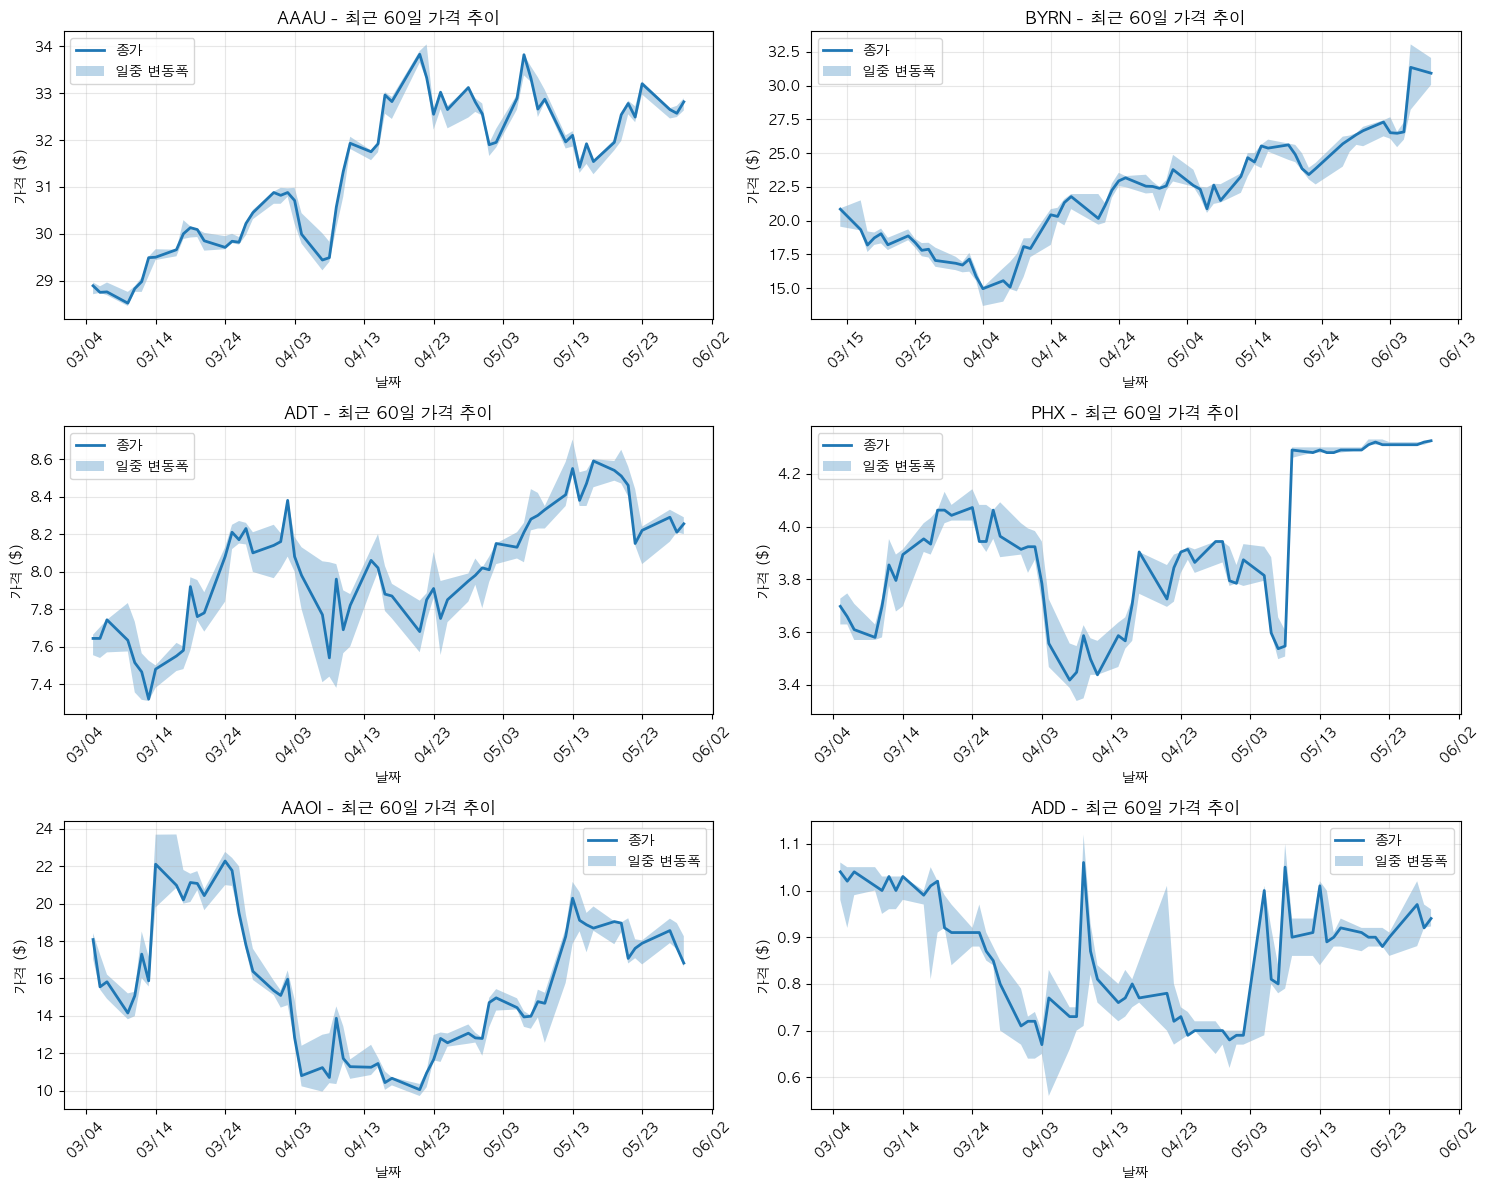


📊 종목별 변동성 분석 (최근 60일):
------------------------------------------------------------
    티커     |    일일 변동성    |   평균 Range   |   Range/종가  
------------------------------------------------------------
   AAAU    |    1.53    % | $   0.35     |    1.12    %
   BYRN    |    5.17    % | $   1.46     |    6.70    %
   ADT     |    1.89    % | $   0.22     |    2.80    %
   PHX     |    3.63    % | $   0.11     |    2.94    %
   AAOI    |    10.21   % | $   1.61     |    10.22   %
   ADD     |    11.11   % | $   0.10     |    11.37   %
------------------------------------------------------------


/var/folders/v3/2dpbvf1x3v77928twwzc9jq80000gn/T/ipykernel_77736/1706233347.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_df['range'] = recent_df['high'] - recent_df['low']
/var/folders/v3/2dpbvf1x3v77928twwzc9jq80000gn/T/ipykernel_77736/1706233347.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_df['range'] = recent_df['high'] - recent_df['low']
/var/folders/v3/2dpbvf1x3v77928twwzc9jq80000gn/T/ipykernel_77736/1706233347.py:41: SettingWithCopyWarning: 
A value is trying to be set on

In [7]:
# 각 종목의 최근 가격 동향 시각화
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, (ticker, df) in enumerate(stock_data.items()):
    if idx < len(axes):
        # 최근 60일 데이터만 표시
        recent_df = df.tail(60)
        
        ax = axes[idx]
        ax.plot(recent_df.index, recent_df['close'], label='종가', linewidth=2)
        ax.fill_between(recent_df.index, recent_df['low'], recent_df['high'], 
                        alpha=0.3, label='일중 변동폭')
        
        ax.set_title(f'{ticker} - 최근 60일 가격 추이', fontsize=12, fontweight='bold')
        ax.set_xlabel('날짜')
        ax.set_ylabel('가격 ($)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # x축 날짜 포맷팅
        ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m/%d'))
        ax.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=10))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# 종목별 변동성 비교
print("\n📊 종목별 변동성 분석 (최근 60일):")
print("-" * 60)
print(f"{'티커':^10} | {'일일 변동성':^12} | {'평균 Range':^12} | {'Range/종가':^12}")
print("-" * 60)

for ticker, df in stock_data.items():
    recent_df = df.tail(60)
    daily_returns = recent_df['close'].pct_change().dropna()
    volatility = daily_returns.std() * 100
    
    # Range = High - Low
    recent_df['range'] = recent_df['high'] - recent_df['low']
    avg_range = recent_df['range'].mean()
    range_pct = (avg_range / recent_df['close'].mean()) * 100
    
    print(f"{ticker:^10} | {volatility:^11.2f}% | ${avg_range:^11.2f} | {range_pct:^11.2f}%")

print("-" * 60)

## 6. 종목별 가격 추이 및 변동성 시각화

## 변동성 돌파 전략 구현

변동성 돌파 전략의 핵심:
1. **Range 계산**: 전일 고가 - 전일 저가
2. **진입가 계산**: 당일 시가 + (Range × K값)
3. **진입 조건**: 장중 주가가 진입가를 돌파하면 매수
4. **청산**: 다음날 시가에 매도

In [8]:
def volatility_breakout_strategy(df, k=0.5):
    """
    변동성 돌파 전략 백테스팅
    
    Parameters:
    - df: 주가 데이터프레임
    - k: K값 (0~1 사이, 기본값 0.5)
    
    Returns:
    - DataFrame: 백테스팅 결과
    """
    # 결과를 저장할 데이터프레임 복사
    result = df.copy()
    
    # 전일 Range 계산 (전일 고가 - 전일 저가)
    result['prev_range'] = (result['high'] - result['low']).shift(1)
    
    # 진입가 계산 (당일 시가 + 전일 Range × K)
    result['target_price'] = result['open'] + (result['prev_range'] * k)
    
    # 매수 신호: 당일 고가가 진입가보다 높으면 매수 발생
    result['buy_signal'] = result['high'] > result['target_price']
    
    # 매수가: 진입가와 당일 고가 중 작은 값 (실제로는 진입가에 매수)
    result['buy_price'] = result['target_price']
    
    # 매도가: 다음날 시가
    result['sell_price'] = result['open'].shift(-1)
    
    # 수익률 계산 (매수 신호가 있는 경우만)
    result['returns'] = 0.0
    buy_condition = result['buy_signal'] == True
    result.loc[buy_condition, 'returns'] = (
        (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
        result.loc[buy_condition, 'buy_price']
    )
    
    # 누적 수익률 계산
    result['cumulative_returns'] = (1 + result['returns']).cumprod()
    
    # Buy & Hold 전략 수익률
    result['buy_hold_returns'] = (result['close'] / result['close'].iloc[0])
    
    return result

# 각 종목에 대해 변동성 돌파 전략 적용
backtest_results = {}
k_value = 0.5  # K값 설정

print(f"\n📊 변동성 돌파 전략 백테스팅 결과 (K={k_value}):")
print("=" * 80)

for ticker, df in stock_data.items():
    # 백테스팅 실행
    result = volatility_breakout_strategy(df, k=k_value)
    backtest_results[ticker] = result
    
    # 성과 지표 계산
    total_trades = result['buy_signal'].sum()
    winning_trades = (result['returns'] > 0).sum()
    win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0
    
    # 전체 수익률
    strategy_return = (result['cumulative_returns'].iloc[-1] - 1) * 100
    buy_hold_return = (result['buy_hold_returns'].iloc[-1] - 1) * 100
    
    # 평균 수익률
    avg_return = result[result['returns'] != 0]['returns'].mean() * 100 if total_trades > 0 else 0
    
    # Sharpe Ratio (연율화)
    daily_returns = result[result['returns'] != 0]['returns']
    sharpe_ratio = (daily_returns.mean() / daily_returns.std() * np.sqrt(252)) if len(daily_returns) > 0 and daily_returns.std() > 0 else 0
    
    print(f"\n{ticker}:")
    print(f"  거래 횟수: {total_trades}회")
    print(f"  승률: {win_rate:.1f}%")
    print(f"  평균 수익률: {avg_return:.2f}%")
    print(f"  전략 누적 수익률: {strategy_return:.1f}%")
    print(f"  Buy&Hold 수익률: {buy_hold_return:.1f}%")
    print(f"  초과 수익률: {strategy_return - buy_hold_return:.1f}%")
    print(f"  Sharpe Ratio: {sharpe_ratio:.2f}")

print("=" * 80)


📊 변동성 돌파 전략 백테스팅 결과 (K=0.5):

AAAU:
  거래 횟수: 395회
  승률: 51.6%
  평균 수익률: 0.06%
  전략 누적 수익률: nan%
  Buy&Hold 수익률: 85.7%
  초과 수익률: nan%
  Sharpe Ratio: 1.16

BYRN:
  거래 횟수: 430회
  승률: 48.6%
  평균 수익률: 0.14%
  전략 누적 수익률: 28.7%
  Buy&Hold 수익률: 43.9%
  초과 수익률: -15.3%
  Sharpe Ratio: 0.55

ADT:
  거래 횟수: 426회
  승률: 47.9%
  평균 수익률: -0.09%
  전략 누적 수익률: -37.1%
  Buy&Hold 수익률: -17.3%
  초과 수익률: -19.8%
  Sharpe Ratio: -0.74

PHX:
  거래 횟수: 430회
  승률: 47.9%
  평균 수익률: -0.01%
  전략 누적 수익률: nan%
  Buy&Hold 수익률: 29.4%
  초과 수익률: nan%
  Sharpe Ratio: -0.03

AAOI:
  거래 횟수: 446회
  승률: 50.9%
  평균 수익률: 0.54%
  전략 누적 수익률: 412.1%
  Buy&Hold 수익률: 100.2%
  초과 수익률: 311.8%
  Sharpe Ratio: 1.46

ADD:
  거래 횟수: 356회
  승률: 42.4%
  평균 수익률: 0.14%
  전략 누적 수익률: -60.2%
  Buy&Hold 수익률: -100.0%
  초과 수익률: 39.7%
  Sharpe Ratio: 0.23


## 7. 변동성 돌파 전략 백테스팅 함수 및 실행

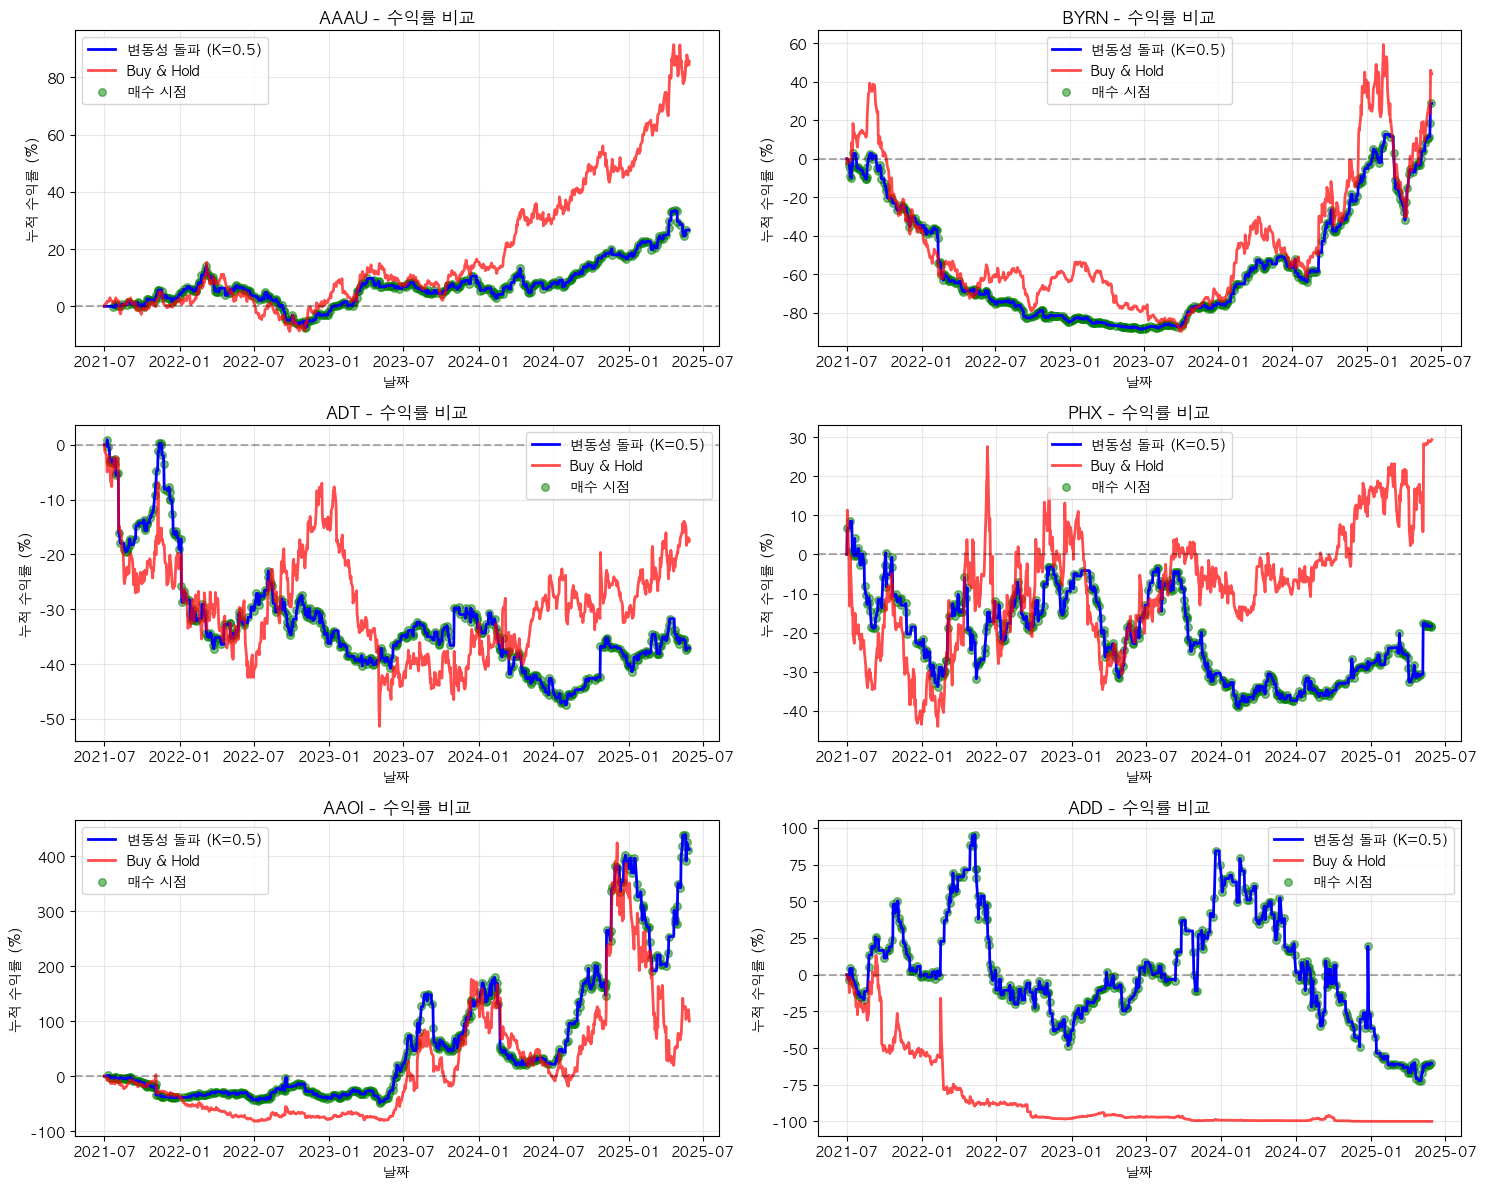

In [9]:
# 전략 수익률 곡선 시각화
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, (ticker, result) in enumerate(backtest_results.items()):
    if idx < len(axes):
        ax = axes[idx]
        
        # 전략 수익률과 Buy&Hold 수익률 비교
        ax.plot(result.index, (result['cumulative_returns'] - 1) * 100, 
                label=f'변동성 돌파 (K={k_value})', linewidth=2, color='blue')
        ax.plot(result.index, (result['buy_hold_returns'] - 1) * 100, 
                label='Buy & Hold', linewidth=2, color='red', alpha=0.7)
        
        # 매수 시점 표시
        buy_points = result[result['buy_signal'] == True]
        ax.scatter(buy_points.index, 
                  (buy_points['cumulative_returns'] - 1) * 100,
                  color='green', s=30, alpha=0.5, label='매수 시점')
        
        ax.set_title(f'{ticker} - 수익률 비교', fontsize=12, fontweight='bold')
        ax.set_xlabel('날짜')
        ax.set_ylabel('누적 수익률 (%)')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        
        # 0% 라인 추가
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. 전략 수익률 곡선 시각화

In [10]:
# K값별 성과 비교
k_values = [0.1, 0.3, 0.5, 0.7, 0.9]
performance_by_k = {}

print("\n📊 K값별 성과 비교:")
print("=" * 100)
print(f"{'티커':^10} | {'K=0.1':^15} | {'K=0.3':^15} | {'K=0.5':^15} | {'K=0.7':^15} | {'K=0.9':^15}")
print("-" * 100)

for ticker, df in stock_data.items():
    ticker_performance = []
    
    for k in k_values:
        result = volatility_breakout_strategy(df, k=k)
        strategy_return = (result['cumulative_returns'].iloc[-1] - 1) * 100
        ticker_performance.append(f"{strategy_return:^14.1f}%")
    
    performance_by_k[ticker] = ticker_performance
    print(f"{ticker:^10} | {''.join(ticker_performance)}")

print("=" * 100)

# 최적 K값 찾기
print("\n🎯 종목별 최적 K값:")
print("-" * 40)

for ticker, df in stock_data.items():
    best_k = 0
    best_return = -float('inf')
    
    for k in k_values:
        result = volatility_breakout_strategy(df, k=k)
        strategy_return = (result['cumulative_returns'].iloc[-1] - 1) * 100
        
        if strategy_return > best_return:
            best_return = strategy_return
            best_k = k
    
    print(f"{ticker}: K={best_k} (수익률: {best_return:.1f}%)")

print("-" * 40)


📊 K값별 성과 비교:
    티커     |      K=0.1      |      K=0.3      |      K=0.5      |      K=0.7      |      K=0.9     
----------------------------------------------------------------------------------------------------
   AAAU    |      nan      %     nan      %     nan      %     12.8     %     10.6     %
   BYRN    |     220.4     %     67.5     %     28.7     %     -6.9     %    -25.9     %
   ADT     |     -34.7     %    -40.0     %    -37.1     %    -36.9     %    -45.5     %
   PHX     |      nan      %     nan      %     nan      %     nan      %     nan      %
   AAOI    |     508.2     %    197.6     %    412.1     %    -10.2     %     13.6     %
   ADD     |      nan      %     nan      %    -60.2     %    -93.2     %    -98.9     %

🎯 종목별 최적 K값:
----------------------------------------
AAAU: K=0.7 (수익률: 12.8%)
BYRN: K=0.1 (수익률: 220.4%)
ADT: K=0.1 (수익률: -34.7%)
PHX: K=0 (수익률: -inf%)
AAOI: K=0.1 (수익률: 508.2%)
ADD: K=0.5 (수익률: -60.2%)
----------------------------------------


## 9. K값별 성과 비교 및 최적화

In [11]:
# 월별 수익률 분석
def analyze_monthly_returns(backtest_results):
    """월별 수익률 분석"""
    
    print("\n📊 월별 수익률 분석 (K=0.5):")
    print("=" * 80)
    
    for ticker, result in backtest_results.items():
        # 거래가 발생한 날짜의 수익률만 추출
        trades = result[result['buy_signal'] == True].copy()
        
        if len(trades) == 0:
            print(f"\n{ticker}: 거래 없음")
            continue
            
        # 월별로 그룹화
        trades['month'] = trades.index.to_period('M')
        monthly_returns = trades.groupby('month')['returns'].agg(['sum', 'count', 'mean'])
        
        print(f"\n{ticker}:")
        print(f"  전체 월 수: {len(monthly_returns)}")
        print(f"  수익 월: {(monthly_returns['sum'] > 0).sum()}개월")
        print(f"  손실 월: {(monthly_returns['sum'] < 0).sum()}개월")
        print(f"  최고 월 수익률: {monthly_returns['sum'].max()*100:.1f}%")
        print(f"  최저 월 수익률: {monthly_returns['sum'].min()*100:.1f}%")
        print(f"  월평균 수익률: {monthly_returns['sum'].mean()*100:.1f}%")

analyze_monthly_returns(backtest_results)


📊 월별 수익률 분석 (K=0.5):

AAAU:
  전체 월 수: 47
  수익 월: 27개월
  손실 월: 20개월
  최고 월 수익률: 6.6%
  최저 월 수익률: -5.3%
  월평균 수익률: 0.5%

BYRN:
  전체 월 수: 48
  수익 월: 26개월
  손실 월: 22개월
  최고 월 수익률: 59.4%
  최저 월 수익률: -44.0%
  월평균 수익률: 1.3%

ADT:
  전체 월 수: 47
  수익 월: 21개월
  손실 월: 26개월
  최고 월 수익률: 9.8%
  최저 월 수익률: -13.3%
  월평균 수익률: -0.8%

PHX:
  전체 월 수: 47
  수익 월: 24개월
  손실 월: 23개월
  최고 월 수익률: 20.3%
  최저 월 수익률: -21.4%
  월평균 수익률: -0.1%

AAOI:
  전체 월 수: 47
  수익 월: 26개월
  손실 월: 21개월
  최고 월 수익률: 69.3%
  최저 월 수익률: -42.2%
  월평균 수익률: 5.1%

ADD:
  전체 월 수: 47
  수익 월: 21개월
  손실 월: 26개월
  최고 월 수익률: 54.3%
  최저 월 수익률: -50.8%
  월평균 수익률: 1.0%


## 10. 월별 수익률 분석

In [12]:
# 최근 거래 신호 확인
print("\n📊 최근 거래 신호 (최근 10일):")
print("=" * 80)

for ticker, result in backtest_results.items():
    recent_data = result.tail(10)
    recent_trades = recent_data[recent_data['buy_signal'] == True]
    
    print(f"\n{ticker}:")
    if len(recent_trades) > 0:
        for date, row in recent_trades.iterrows():
            print(f"  {date.strftime('%Y-%m-%d')}: 진입가 ${row['target_price']:.2f}, "
                  f"매수가 ${row['buy_price']:.2f}, 수익률 {row['returns']*100:.1f}%")
    else:
        print("  최근 10일간 거래 신호 없음")
    
    # 오늘의 진입가 (마지막 행이 오늘이라고 가정)
    if len(result) > 0:
        today = result.iloc[-1]
        print(f"  📌 내일 진입가: ${today['open']:.2f} + (${today['high'] - today['low']:.2f} × {k_value}) = "
              f"${today['open'] + (today['high'] - today['low']) * k_value:.2f}")

print("=" * 80)


📊 최근 거래 신호 (최근 10일):

AAAU:
  2025-05-15: 진입가 $31.67, 매수가 $31.67, 수익률 -0.9%
  2025-05-20: 진입가 $32.12, 매수가 $32.12, 수익률 1.6%
  2025-05-29: 진입가 $32.88, 매수가 $32.88, 수익률 nan%
  📌 내일 진입가: $32.76 + ($0.26 × 0.5) = $32.89

BYRN:
  2025-05-27: 진입가 $25.12, 매수가 $25.12, 수익률 2.3%
  2025-05-30: 진입가 $26.56, 매수가 $26.56, 수익률 0.5%
  2025-06-02: 진입가 $27.40, 매수가 $27.40, 수익률 0.4%
  2025-06-05: 진입가 $27.10, 매수가 $27.10, 수익률 6.4%
  2025-06-06: 진입가 $29.48, 매수가 $29.48, 수익률 8.5%
  📌 내일 진입가: $32.00 + ($2.00 × 0.5) = $33.00

ADT:
  2025-05-15: 진입가 $8.44, 매수가 $8.44, 수익률 0.2%
  2025-05-16: 진입가 $8.55, 매수가 $8.55, 수익률 -0.4%
  2025-05-20: 진입가 $8.56, 매수가 $8.56, 수익률 -1.9%
  2025-05-21: 진입가 $8.49, 매수가 $8.49, 수익률 -0.9%
  2025-05-23: 진입가 $8.23, 매수가 $8.23, 수익률 0.6%
  📌 내일 진입가: $8.29 + ($0.09 × 0.5) = $8.33

PHX:
  2025-05-15: 진입가 $4.29, 매수가 $4.29, 수익률 -0.2%
  2025-05-16: 진입가 $4.29, 매수가 $4.29, 수익률 -0.0%
  2025-05-19: 진입가 $4.30, 매수가 $4.30, 수익률 0.5%
  2025-05-20: 진입가 $4.32, 매수가 $4.32, 수익률 -0.3%
  2025-05-21: 진입가 $4.32, 매수가 $4.32

## 11. 최근 거래 신호 및 내일 진입가 확인

In [13]:
# Buy & Hold 전략 상세 설명
print("\n📊 Buy & Hold 전략 상세 내역:")
print("=" * 80)

for ticker, df in stock_data.items():
    start_date = df.index[0]
    end_date = df.index[-1]
    start_price = df['close'].iloc[0]
    end_price = df['close'].iloc[-1]
    
    buy_hold_return = ((end_price - start_price) / start_price) * 100
    
    print(f"\n{ticker}:")
    print(f"  매수일: {start_date.strftime('%Y-%m-%d')} (시작일)")
    print(f"  매수가: ${start_price:.2f}")
    print(f"  평가일: {end_date.strftime('%Y-%m-%d')} (종료일)")
    print(f"  평가가: ${end_price:.2f}")
    print(f"  보유 기간: {(end_date - start_date).days}일")
    print(f"  Buy & Hold 수익률: {buy_hold_return:.1f}%")
    
    # 변동성 돌파와 비교
    vb_return = (backtest_results[ticker]['cumulative_returns'].iloc[-1] - 1) * 100
    print(f"  변동성 돌파 수익률: {vb_return:.1f}%")
    print(f"  차이: {vb_return - buy_hold_return:+.1f}%")

print("=" * 80)


📊 Buy & Hold 전략 상세 내역:

AAAU:
  매수일: 2021-07-01 (시작일)
  매수가: $17.67
  평가일: 2025-05-29 (종료일)
  평가가: $32.81
  보유 기간: 1428일
  Buy & Hold 수익률: 85.7%
  변동성 돌파 수익률: nan%
  차이: +nan%

BYRN:
  매수일: 2021-07-01 (시작일)
  매수가: $21.48
  평가일: 2025-06-09 (종료일)
  평가가: $30.92
  보유 기간: 1439일
  Buy & Hold 수익률: 43.9%
  변동성 돌파 수익률: 28.7%
  차이: -15.3%

ADT:
  매수일: 2021-07-01 (시작일)
  매수가: $9.98
  평가일: 2025-05-29 (종료일)
  평가가: $8.26
  보유 기간: 1428일
  Buy & Hold 수익률: -17.3%
  변동성 돌파 수익률: -37.1%
  차이: -19.8%

PHX:
  매수일: 2021-07-01 (시작일)
  매수가: $3.34
  평가일: 2025-05-29 (종료일)
  평가가: $4.32
  보유 기간: 1428일
  Buy & Hold 수익률: 29.4%
  변동성 돌파 수익률: nan%
  차이: +nan%

AAOI:
  매수일: 2021-07-01 (시작일)
  매수가: $8.40
  평가일: 2025-05-29 (종료일)
  평가가: $16.82
  보유 기간: 1428일
  Buy & Hold 수익률: 100.2%
  변동성 돌파 수익률: 412.1%
  차이: +311.8%

ADD:
  매수일: 2021-07-01 (시작일)
  매수가: $4240.00
  평가일: 2025-05-29 (종료일)
  평가가: $0.94
  보유 기간: 1428일
  Buy & Hold 수익률: -100.0%
  변동성 돌파 수익률: -60.2%
  차이: +39.7%


## 12. Buy & Hold 전략과의 상세 비교

In [14]:
# 거래 빈도 상세 분석
print("\n📊 거래 빈도 상세 분석 (K=0.5):")
print("=" * 80)

for ticker, result in backtest_results.items():
    # 전체 거래일 수와 거래 발생일 수
    total_days = len(result)
    trade_days = result['buy_signal'].sum()
    
    # 연간 거래 횟수 계산 (거래일 기준 연 252일)
    years = total_days / 252
    annual_trades = trade_days / years if years > 0 else 0
    
    # 거래 빈도
    trade_frequency = (trade_days / total_days * 100) if total_days > 0 else 0
    
    print(f"\n{ticker}:")
    print(f"  전체 거래일: {total_days}일 ({years:.1f}년)")
    print(f"  실제 거래 발생: {trade_days}회")
    print(f"  연평균 거래 횟수: {annual_trades:.0f}회")
    print(f"  거래 빈도: {trade_frequency:.1f}% (평균 {100/trade_frequency:.0f}일에 1번 거래)")
    
    # 월별 거래 횟수
    result['month'] = result.index.to_period('M')
    monthly_trades = result.groupby('month')['buy_signal'].sum()
    
    print(f"  월평균 거래: {monthly_trades.mean():.1f}회")
    print(f"  최다 거래 월: {monthly_trades.max()}회")
    print(f"  최소 거래 월: {monthly_trades.min()}회")

print("\n💡 거래 빈도가 높은 이유:")
print("  - K=0.5는 전일 변동폭의 50%만 상승해도 진입")
print("  - 변동성이 큰 종목일수록 진입 기회가 많음")
print("  - K값을 높이면 거래 빈도 감소 (K=0.7, 0.9 등)")
print("=" * 80)


📊 거래 빈도 상세 분석 (K=0.5):

AAAU:
  전체 거래일: 982일 (3.9년)
  실제 거래 발생: 395회
  연평균 거래 횟수: 101회
  거래 빈도: 40.2% (평균 2일에 1번 거래)
  월평균 거래: 8.4회
  최다 거래 월: 15회
  최소 거래 월: 3회

BYRN:
  전체 거래일: 989일 (3.9년)
  실제 거래 발생: 430회
  연평균 거래 횟수: 110회
  거래 빈도: 43.5% (평균 2일에 1번 거래)
  월평균 거래: 9.0회
  최다 거래 월: 15회
  최소 거래 월: 3회

ADT:
  전체 거래일: 982일 (3.9년)
  실제 거래 발생: 426회
  연평균 거래 횟수: 109회
  거래 빈도: 43.4% (평균 2일에 1번 거래)
  월평균 거래: 9.1회
  최다 거래 월: 14회
  최소 거래 월: 5회

PHX:
  전체 거래일: 982일 (3.9년)
  실제 거래 발생: 430회
  연평균 거래 횟수: 110회
  거래 빈도: 43.8% (평균 2일에 1번 거래)
  월평균 거래: 9.1회
  최다 거래 월: 15회
  최소 거래 월: 4회

AAOI:
  전체 거래일: 982일 (3.9년)
  실제 거래 발생: 446회
  연평균 거래 횟수: 114회
  거래 빈도: 45.4% (평균 2일에 1번 거래)
  월평균 거래: 9.5회
  최다 거래 월: 16회
  최소 거래 월: 5회

ADD:
  전체 거래일: 982일 (3.9년)
  실제 거래 발생: 356회
  연평균 거래 횟수: 91회
  거래 빈도: 36.3% (평균 3일에 1번 거래)
  월평균 거래: 7.6회
  최다 거래 월: 14회
  최소 거래 월: 4회

💡 거래 빈도가 높은 이유:
  - K=0.5는 전일 변동폭의 50%만 상승해도 진입
  - 변동성이 큰 종목일수록 진입 기회가 많음
  - K값을 높이면 거래 빈도 감소 (K=0.7, 0.9 등)


## 13. 거래 빈도 상세 분석

In [15]:
# K값별 거래 빈도 비교
print("\n📊 K값별 거래 빈도 비교:")
print("=" * 80)
print(f"{'티커':^10} | {'K=0.3':^20} | {'K=0.5':^20} | {'K=0.7':^20} | {'K=0.9':^20}")
print(f"{'':^10} | {'연간거래':^10}{'수익률':^10} | {'연간거래':^10}{'수익률':^10} | {'연간거래':^10}{'수익률':^10} | {'연간거래':^10}{'수익률':^10}")
print("-" * 80)

for ticker, df in stock_data.items():
    row_data = f"{ticker:^10} |"
    
    for k in [0.3, 0.5, 0.7, 0.9]:
        result = volatility_breakout_strategy(df, k=k)
        
        # 거래 횟수와 수익률 계산
        total_days = len(result)
        trade_days = result['buy_signal'].sum()
        years = total_days / 252
        annual_trades = trade_days / years if years > 0 else 0
        strategy_return = (result['cumulative_returns'].iloc[-1] - 1) * 100
        
        row_data += f" {annual_trades:^9.0f}회{strategy_return:^9.1f}% |"
    
    print(row_data)

print("=" * 80)
print("\n💡 K값 선택 가이드:")
print("  - K=0.3: 자주 거래 (연 100회 이상) - 공격적")
print("  - K=0.5: 적당한 빈도 (연 50-100회) - 균형적") 
print("  - K=0.7: 가끔 거래 (연 30-50회) - 보수적")
print("  - K=0.9: 매우 드물게 (연 20회 미만) - 매우 보수적")


📊 K값별 거래 빈도 비교:
    티커     |        K=0.3         |        K=0.5         |        K=0.7         |        K=0.9        
           |    연간거래      수익률     |    연간거래      수익률     |    연간거래      수익률     |    연간거래      수익률    
--------------------------------------------------------------------------------
   AAAU    |    146   회   nan   % |    101   회   nan   % |    73    회  12.8   % |    48    회  10.6   % |
   BYRN    |    155   회  67.5   % |    110   회  28.7   % |    77    회  -6.9   % |    54    회  -25.9  % |
   ADT     |    160   회  -40.0  % |    109   회  -37.1  % |    73    회  -36.9  % |    50    회  -45.5  % |
   PHX     |    156   회   nan   % |    110   회   nan   % |    74    회   nan   % |    52    회   nan   % |
   AAOI    |    158   회  197.6  % |    114   회  412.1  % |    82    회  -10.2  % |    55    회  13.6   % |
   ADD     |    141   회   nan   % |    91    회  -60.2  % |    73    회  -93.2  % |    60    회  -98.9  % |

💡 K값 선택 가이드:
  - K=0.3: 자주 거래 (연 100회 이상) - 공격적
  - K=0.5: 적당한 빈도

## 14. K값별 거래 빈도와 수익률 트레이드오프

In [16]:
# 수익률 곡선의 품질 분석
def analyze_equity_curve_quality(result):
    """수익률 곡선의 품질을 분석하는 함수"""
    returns = result['returns']
    cumulative = result['cumulative_returns']
    
    # 1. 최대 낙폭 (MDD) 계산
    rolling_max = cumulative.expanding().max()
    drawdown = (cumulative - rolling_max) / rolling_max * 100
    max_drawdown = drawdown.min()
    
    # 2. 승률
    win_rate = (returns > 0).sum() / (returns != 0).sum() * 100 if (returns != 0).sum() > 0 else 0
    
    # 3. 수익률의 일관성 (낮을수록 좋음)
    returns_std = returns[returns != 0].std() * 100 if len(returns[returns != 0]) > 0 else 0
    
    # 4. Calmar Ratio (연수익률 / MDD)
    annual_return = ((cumulative.iloc[-1] ** (252/len(cumulative))) - 1) * 100
    calmar_ratio = abs(annual_return / max_drawdown) if max_drawdown != 0 else 0
    
    return {
        'mdd': max_drawdown,
        'win_rate': win_rate,
        'volatility': returns_std,
        'calmar_ratio': calmar_ratio,
        'annual_return': annual_return
    }

# 각 종목의 수익률 곡선 품질 평가
print("\n📊 수익률 곡선 품질 평가 (K=0.5):")
print("=" * 100)
print(f"{'티커':^10} | {'MDD':^10} | {'승률':^10} | {'일일변동성':^12} | {'연수익률':^12} | {'Calmar':^10} | {'평가':^10}")
print("-" * 100)

curve_quality = {}
for ticker, result in backtest_results.items():
    quality = analyze_equity_curve_quality(result)
    curve_quality[ticker] = quality
    
    # 품질 평가
    if quality['mdd'] > -10 and quality['win_rate'] > 50 and quality['calmar_ratio'] > 1:
        evaluation = "우수"
    elif quality['mdd'] > -20 and quality['win_rate'] > 45:
        evaluation = "양호"
    else:
        evaluation = "보통"
    
    print(f"{ticker:^10} | {quality['mdd']:^9.1f}% | {quality['win_rate']:^9.1f}% | "
          f"{quality['volatility']:^11.2f}% | {quality['annual_return']:^11.1f}% | "
          f"{quality['calmar_ratio']:^9.2f} | {evaluation:^10}")

print("=" * 100)

print("\n💡 이상적인 수익률 곡선의 조건:")
print("  1. MDD(최대낙폭) < -10%: 큰 손실 없이 안정적")
print("  2. 승률 > 50%: 이기는 거래가 더 많음")
print("  3. 일일 변동성 낮음: 수익이 일정함")
print("  4. Calmar Ratio > 1: 위험 대비 수익이 좋음")
print("\n현실: 완벽한 우상향은 거의 불가능, '양호' 수준도 충분히 좋은 전략")


📊 수익률 곡선 품질 평가 (K=0.5):
    티커     |    MDD     |     승률     |    일일변동성     |     연수익률     |   Calmar   |     평가    
----------------------------------------------------------------------------------------------------
   AAAU    |   -19.1  % |   51.8   % |    0.88    % |     nan    % |    nan    |     양호    
   BYRN    |   -88.8  % |   48.6   % |    4.11    % |     6.6    % |   0.07    |     보통    
   ADT     |   -47.9  % |   47.9   % |    1.92    % |    -11.2   % |   0.23    |     보통    
   PHX     |   -43.9  % |   47.9   % |    2.89    % |     nan    % |    nan    |     보통    
   AAOI    |   -57.2  % |   51.0   % |    5.86    % |    52.1    % |   0.91    |     보통    
   ADD     |   -85.9  % |   45.1   % |    9.58    % |    -21.1   % |   0.25    |     보통    

💡 이상적인 수익률 곡선의 조건:
  1. MDD(최대낙폭) < -10%: 큰 손실 없이 안정적
  2. 승률 > 50%: 이기는 거래가 더 많음
  3. 일일 변동성 낮음: 수익이 일정함
  4. Calmar Ratio > 1: 위험 대비 수익이 좋음

현실: 완벽한 우상향은 거의 불가능, '양호' 수준도 충분히 좋은 전략


## 15. 수익률 곡선 품질 평가 (MDD, Sharpe, Calmar)

In [17]:
# 수익률 곡선의 직선성 측정
import scipy.stats as stats

print("\n📊 수익률 곡선의 직선성 분석:")
print("=" * 80)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (ticker, result in enumerate(backtest_results.items()):
    if idx < 6:
        ax = axes[idx]
        
        # 누적 수익률 데이터
        cum_returns = (result['cumulative_returns'] - 1) * 100
        days = np.arange(len(cum_returns))
        
        # 선형 회귀
        slope, intercept, r_value, p_value, std_err = stats.linregress(days, cum_returns)
        line = slope * days + intercept
        
        # R² 값 (결정계수) - 1에 가까울수록 직선에 가까움
        r_squared = r_value**2
        
        # 플롯
        ax.plot(cum_returns.values, label='실제 수익률', linewidth=2)
        ax.plot(line, '--', label=f'추세선 (R²={r_squared:.3f})', linewidth=2, alpha=0.7)
        
        ax.set_title(f'{ticker} - 직선성: {r_squared:.3f}')
        ax.set_xlabel('거래일')
        ax.set_ylabel('누적 수익률 (%)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 배경색으로 품질 표시
        if r_squared > 0.8:
            ax.set_facecolor('#e8f5e9')  # 연한 초록
        elif r_squared > 0.6:
            ax.set_facecolor('#fff9c4')  # 연한 노랑
        else:
            ax.set_facecolor('#ffebee')  # 연한 빨강

plt.tight_layout()
plt.show()

print("\n💡 R² (결정계수) 해석:")
print("  - 0.8 이상: 매우 직선적 (이상적)")
print("  - 0.6-0.8: 비교적 직선적 (양호)")
print("  - 0.6 미만: 변동성 큼 (보통)")
print("\n실제로 R² > 0.8인 전략은 매우 드뭅니다!")

SyntaxError: invalid syntax (3974564636.py, line 10)

## 16. 수익률 곡선의 직선성 분석 (R² 분석)